<a href="https://colab.research.google.com/github/MithunSrinivas28/Fluxo_AI_Supplychain/blob/main/final_demand_forecasting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/synthetic_supplychain_data.csv')

df.head()

,product_id,product_name,category,zone,warehouse,year,week,month,is_festival,base_demand,base_price,current_price,discount_percent,zone_multiplier,warehouse_multiplier,year_growth,units_sold_next_week
0,1,Fertilizer,agriculture,North,A,1.0,1.0,1.0,0.0,627,278,271.024431,15,1.05,0.959,1.0,875
1,1,Fertilizer,agriculture,North,A,1.0,2.0,1.0,0.0,627,278,258.874636,0,1.05,0.959,1.0,738
2,1,Fertilizer,agriculture,North,A,1.0,3.0,1.0,0.0,627,278,253.429449,10,1.05,0.959,1.0,903
3,1,Fertilizer,agriculture,North,A,1.0,4.0,1.0,0.0,627,278,251.344498,15,1.05,0.959,1.0,934
4,1,Fertilizer,agriculture,North,A,1.0,5.0,2.0,0.0,627,278,296.483811,0,1.05,0.959,1.0,577


# STEP 2 — Sort Data Chronologically

In [67]:
df = df.sort_values(
    by=["product_id", "zone", "warehouse", "year", "week"]
)

df.head()

,product_id,product_name,category,zone,warehouse,year,week,month,is_festival,base_demand,base_price,current_price,discount_percent,zone_multiplier,warehouse_multiplier,year_growth,units_sold_next_week
936,1,Fertilizer,agriculture,East,A,1.0,1.0,1.0,0.0,627,278,267.597651,0,1.1,1.004,1.0,764
937,1,Fertilizer,agriculture,East,A,1.0,2.0,1.0,0.0,627,278,302.838395,0,1.1,1.004,1.0,653
938,1,Fertilizer,agriculture,East,A,1.0,3.0,1.0,0.0,627,278,258.808471,15,1.1,1.004,1.0,988
939,1,Fertilizer,agriculture,East,A,1.0,4.0,1.0,0.0,627,278,261.466374,0,1.1,1.004,1.0,744
940,1,Fertilizer,agriculture,East,A,1.0,5.0,2.0,0.0,627,278,289.183361,0,1.1,1.004,1.0,658


# STEP 3 — Create Lag Features (Temporal Memory)

In [68]:
df["lag_1"] = df.groupby(
    ["product_id", "zone", "warehouse"]
)["units_sold_next_week"].shift(1)

df["lag_2"] = df.groupby(
    ["product_id", "zone", "warehouse"]
)["units_sold_next_week"].shift(2)

df = df.dropna()

df[["lag_1", "lag_2"]].head()

,lag_1,lag_2
938,653.0,764.0
939,988.0,653.0
940,744.0,988.0
941,658.0,744.0
942,680.0,658.0


# STEP 4 — Define Final Feature Set

In [69]:
X = df[[
    "current_price",
    "base_price",
    "discount_percent",
    "year_growth",
    "month",
    "is_festival",
    "product_id",
    "zone",
    "warehouse",
    "category",
    "lag_1",
    "lag_2",
    "year"
]]

y = df["units_sold_next_week"]

X.head()

,current_price,base_price,discount_percent,year_growth,month,is_festival,product_id,zone,warehouse,category,lag_1,lag_2,year
938,258.808471,278,15,1.0,1.0,0.0,1,East,A,agriculture,653.0,764.0,1.0
939,261.466374,278,0,1.0,1.0,0.0,1,East,A,agriculture,988.0,653.0,1.0
940,289.183361,278,0,1.0,2.0,0.0,1,East,A,agriculture,744.0,988.0,1.0
941,282.610689,278,0,1.0,2.0,0.0,1,East,A,agriculture,658.0,744.0,1.0
942,275.234136,278,15,1.0,2.0,0.0,1,East,A,agriculture,680.0,658.0,1.0


# STEP 5 — Time-Based Train/Test Split

In [70]:
train = X[X["year"] < 3]
test = X[X["year"] == 3]

y_train = y[X["year"] < 3]
y_test = y[X["year"] == 3]

# Remove year after split
train = train.drop(columns=["year"])
test = test.drop(columns=["year"])

train.shape, test.shape

((29376, 12), (14976, 12))

# STEP 6 — One-Hot Encode Categorical Features

XGBoost requires purely numeric input.

We convert:

zone

warehouse

category

into numeric columns.

In [71]:
train = pd.get_dummies(
    train,
    columns=["zone", "warehouse", "category"],
    drop_first=True
)

test = pd.get_dummies(
    test,
    columns=["zone", "warehouse", "category"],
    drop_first=True
)

# VERY IMPORTANT — align columns
train, test = train.align(test, join="left", axis=1, fill_value=0)

train.shape, test.shape

((29376, 22), (14976, 22))

# STEP 7 — Train XGBoost (Final Model)

In [72]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(train, y_train)

predictions = xgb_model.predict(test)

# STEP 8 — Evaluate Model

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 46.39262008666992
RMSE: 70.17576287659793
MAPE: 7.329892766391535


# **🚀 Step 1 — Install Latest XGBoost**

In [74]:
!pip install --upgrade xgboost

# Step 2 — Train Quantile Models

We train 3 models:

q=0.05

q=0.5

q=0.95

In [75]:
from xgboost import XGBRegressor

xgb_lower = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.05,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_lower.fit(train, y_train)
lower_preds = xgb_lower.predict(test)

In [76]:
xgb_median = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.5,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_median.fit(train, y_train)
median_preds = xgb_median.predict(test)

In [77]:
xgb_upper = XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.99,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_upper.fit(train, y_train)
upper_preds = xgb_upper.predict(test)

# Step 3 — Visualize Prediction Interval

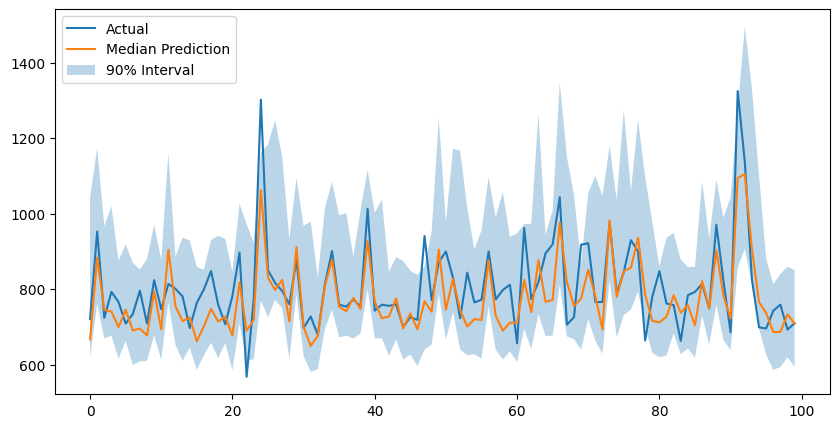

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label="Actual")
plt.plot(median_preds[:100], label="Median Prediction")
plt.fill_between(
    range(100),
    lower_preds[:100],
    upper_preds[:100],
    alpha=0.3,
    label="90% Interval"
)
plt.legend()
plt.show()

In [79]:
coverage = np.mean(
    (y_test >= lower_preds) & (y_test <= upper_preds)
)

print("Interval Coverage:", coverage)

Interval Coverage: 0.9109909188034188


In [80]:
interval_width = np.mean(upper_preds - lower_preds)
print("Average Interval Width:", interval_width)

Average Interval Width: 283.23605


In [81]:
misses = y_test[(y_test < lower_preds) | (y_test > upper_preds)]
print("Number of misses:", len(misses))
print("Total test samples:", len(y_test))

Number of misses: 1333
Total test samples: 14976


In [82]:
high_misses = y_test[y_test > upper_preds]
low_misses = y_test[y_test < lower_preds]

print("High-side misses:", len(high_misses))
print("Low-side misses:", len(low_misses))

High-side misses: 556
Low-side misses: 777


In [83]:
coverage = np.mean(
    (y_test >= lower_preds) & (y_test <= upper_preds)
)

print("New Coverage:", coverage)

New Coverage: 0.9109909188034188


In [84]:
full_X = pd.get_dummies(
    X.drop(columns=["year"]),
    columns=["zone", "warehouse", "category"],
    drop_first=True
)

xgb_lower.fit(full_X, y)
xgb_median.fit(full_X, y)
xgb_upper.fit(full_X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

# ***NEXT STEP — Save Production Artifacts***

In [85]:
import joblib

joblib.dump(xgb_lower, "xgb_lower.pkl")
joblib.dump(xgb_median, "xgb_median.pkl")
joblib.dump(xgb_upper, "xgb_upper.pkl")
joblib.dump(full_X.columns, "feature_columns.pkl")

['feature_columns.pkl']